In [1]:
using Distributed
# addprocs(47)
ifelse(nprocs()<2, addprocs(2), nothing);

In [2]:
nprocs()

3

# Paper effective model

In [3]:
using LinearAlgebra
# using Plots
# pyplot()

In [1]:
using Revise
using LatticeQM
using LatticeQM.Meanfield

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1278
┌ Info: Precompiling LatticeQM [606d2a7e-9b17-11e9-1c5c-455b84f60309]
└ @ Base loading.jl:1278


In [2]:
# Linear interpolation between the two parameter regimes
e0 = 1
t1(s) = e0 * (0.04)          * (1-s) + s * e0 * (0.06+0.05im)
t2(s) = e0 * (0.10 - 0.04im) * (1-s) + s * e0 * (0.06-0.05im)

t2 (generic function with 1 method)

In [4]:
lat = Geometries2D.triangular_supercell()
slat = Structure.superlattice(lat, [[3,0] [0,3]])
Structure.foldPC!(slat; shift=[0.2,0.0,0.0])
# plot(slat, [0.0 for i in 1:Structure.countorbitals(slat)]; supercell=0, size=(200,200))

Lattice dimension:     2
Space dimension:       3
Number of atoms:       27
Non-spatial dimension: 1
Basis:
3×3 Array{Float64,2}:
 5.19615  -2.59808  0.0
 0.0       4.5      0.0
 0.0       0.0      1.0
Orbital/atom coordinates: 
4×27 Array{Float64,2}:
 -0.2  0.0222222  -0.0888889  0.133333  …   0.133333   0.355556   0.244444
  0.0  0.111111    0.222222   0.0          -0.333333  -0.222222  -0.111111
  0.0  0.0         0.0        0.0           0.0        0.0        0.0
  1.0  2.0         3.0        1.0           1.0        2.0        3.0

In [7]:
# Set up lattice
lat0 = Geometries2D.triangular()
sz0 = getoperator(lat0, "sz")

lat = Geometries2D.triangular_supercell()
ks = kpath(lat, ["M2","Γ", "K", "M", "K'", "Γ", "M"]; num_points=500)
sz = getoperator(lat, "sz")
sub1, sub2, sub3 = [getoperator(lat, "sublattice", i, 2) for i=1:3]

slat = Structure.superlattice(lat, [[3,0] [0,3]])
Structure.foldPC!(slat; shift=[0.2,0.0,0.0])
ks2 = kpath(slat, ["M2","Γ", "K", "M", "K'", "Γ", "M"]; num_points=100)
sz2 = getoperator(slat, "sz")

nothing

In [8]:
# Get nearest-neighbor hops in the honeycomb lattice
s = 0.0
hops0 = Operators.gethaldanelike(lat0; t1=t1(s), t2=t2(s))
hops = Operators.gethaldanelike(lat; t1=t1(s), t2=t2(s))
hops2 = Operators.gethaldanelike(slat; t1=t1(s), t2=t2(s))
nothing

In [9]:
bands = getbands(hops0, ks, sz0; format=:dense)
# bands = getbands(hops2, ks2, sz2; format=:dense)
# p = plot(bands; markercolor=:PiYG, size=(400,130))
# p

Computing bands... 100%|████████████████████████████████| Time: 0:00:05


Number of bands:      2
Number of k-points:   500
Number of observables: 1
Discrete Path: M$_2$→$\Gamma$→$K$→$M$→$K'$→$\Gamma$→$M$  (500 points)


In [10]:
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [12]:
v = gethubbard(slat; mode=:σx, a=0.5, U=0.8) # interaction potential
ρ_init = 0.0 * initialguess(v, :ferro; lat=slat) + 1.0 * initialguess(v, :random; lat=slat) # initial guess

hf = hartreefock(hops2, v)

@time ρ_sol, ϵ_GS, HMF, converged, error = solveselfconsistent( # run the calculation
    hf, ρ_init, 0.5; klin=5, parallel=true, iterations=300, tol=1e-7,# p_norm=Inf,
    T=0.0001, β=0.30,  show_trace=true, clear_trace=true, verbose=false
)

# m1,m2,m3 = real.(Operators.magnetization(ρ_sol, [sub1,sub2,sub3], lat))
M = Operators.localmagnetization(ρ_sol, slat)
m = sum(M; dims=2)
Mabs = norm(m)
dens = Operators.density(ρ_sol)
@info("Groundstate energy", ϵ_GS)
@info("Magnetizations", Mabs, norm(M[:,1]), norm(M[:,2]), norm(M[:,3]))
@info("Magnetization vectors", Mabs, m, M)
@info("Density", dens)

# Get the bands without mean-field terms
ks = kpath(slat; num_points=200)
bands = getbands(hops2, ks, sz2)

# Get the bands with mean-field terms
bands_mf = getbands(HMF.h, ks, sz2)
bands_mf.bands .-= HMF.μ

###################################################################################################
###################################################################################################

using DelimitedFiles
XYZ = transpose(Structure.positions(slat))
mkpath("output"); writedlm("output/positions.out", XYZ)
mkpath("output"); writedlm("output/magnetization.out", M)


FIXPOINT SEARCH  (thresh = 1e-07, value = 0.000881198)
4m  iter:  300

57.620032 seconds (8.40 M allocations: 1.639 GiB, 0.86% gc time)


┌ Info: Groundstate energy
│   ϵ_GS = -2.125118489651082
└ @ Main In[12]:16
┌ Info: Magnetizations
│   Mabs = 1.544028735170689e-6
│   norm(M[:, 1]) = 0.8359658389562002
│   norm(M[:, 2]) = 0.8358470349553011
│   norm(M[:, 3]) = 0.8357633116782075
└ @ Main In[12]:17
┌ Info: Magnetization vectors
│   Mabs = 1.544028735170689e-6
│   m = [-6.868557300698797e-7; -1.382794272974941e-6; 1.1573233371642289e-8]
│   M = [-0.33701028857225196 -0.08375767075675253 0.5559719037847399 0.8310349810656834 0.7621008040218178 -0.8183989331102844 -0.4940461122798099 -0.6783410070898879 0.2624281951665884 -0.4940109264105655 -0.6783444485912159 0.2624195550610237 -0.33700551813627055 -0.08375906463722582 0.5559738936856626 0.8310343724000748 0.7620997384206831 -0.8183994573933094 0.8310344414145407 0.7620980396482264 -0.8183976983224084 -0.4940289642801835 -0.6783442645035157 0.2624260295348291 -0.3370028682251914 -0.08375197329508147 0.555976554544354; 0.7650234836502033 0.8316398939455866 -0.6240156131

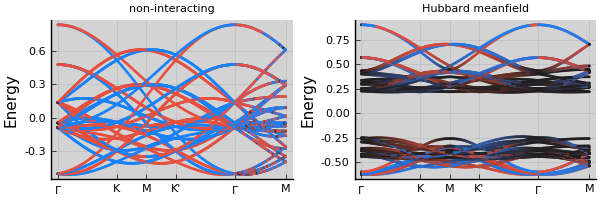

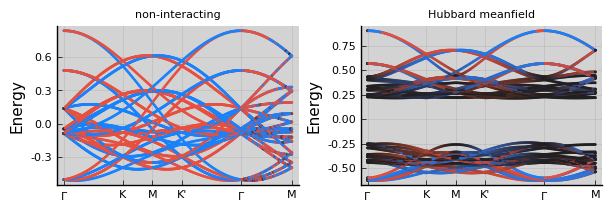

In [13]:
let bands=bands, bands_mf=bands_mf
    using Plots
    
    p1 = plot(bands; markersize=2, size=(600,200))
    p2 = plot(bands_mf; markersize=2, size=(600,200))

    plot!(p1, title="non-interacting")
    plot!(p2, title="Hubbard meanfield")
    p = plot(p1,p2, titlefont=font(8))
    display(p)

    mkpath("output"); savefig("output/bandsmeanfield.pdf")
end

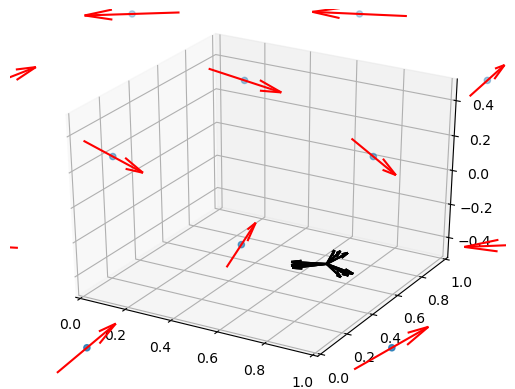

In [26]:
let XYZ=XYZ, M=transpose(M)
    using PyPlot
    #pygui(true)
    using3D()

    fig = figure()
    ax = fig.gca(projection="3d")

    ax.scatter(eachcol(XYZ)...)
    ax.quiver(eachcol(XYZ)..., eachcol(M)..., length=0.5, pivot="middle", color="r")
    ax.quiver(sum(eachrow(XYZ))/3..., eachcol(M)..., length=0.15, pivot="tail", color="k")
    ax.set_xlim3d([0.0,1.0])
    ax.set_ylim3d([0.0,1.0])
    ax.set_zlim3d([-0.5,0.5])
    show()
end